California Housing Prices dataset contains 20,640 observations with 8 numerical features (longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income) and target median_house_value for regression. It's suitable (>10k samples) for predicting house prices (regression problem).

In [2]:
# Dataset: https://www.kaggle.com/datasets/camnugent/california-housing-prices

#required libraries
!pip install torch torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices
(20640, 10)
Cleaned shape: (20640, 9)


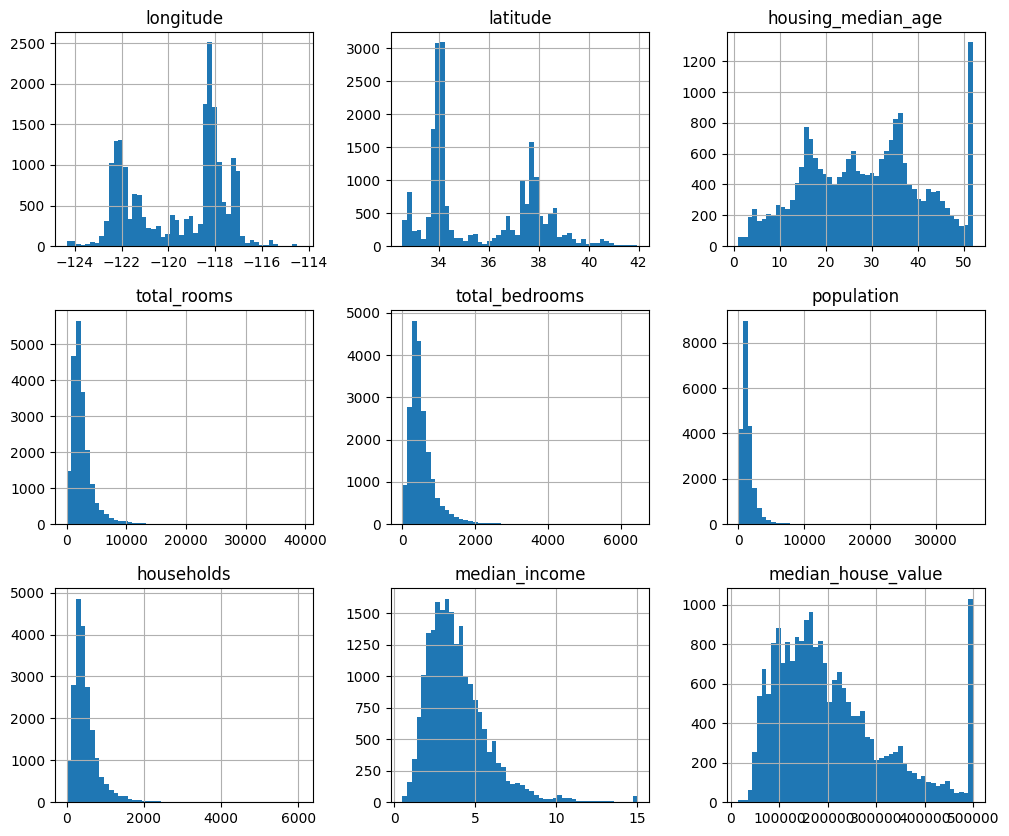

In [9]:
import kagglehub
path = kagglehub.dataset_download("camnugent/california-housing-prices")
print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/housing.csv")
print(df.shape)
df = df.drop('ocean_proximity', axis=1)#drop categorical
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df.iloc[:, :] = imputer.fit_transform(df) #fill NaNs
print("Cleaned shape:", df.shape)
#then continue with EDA/splits/models...
df.describe()
df.hist(bins=50, figsize=(12,10))
plt.show()
X = df.drop('median_house_value', axis=1).values[:10000]
y = df['median_house_value'].values[:10000].reshape(-1,1)


Part 1: NeuralNetwork Class from Scratch
Implemented a simple feedforward NN with one hidden layer (sigmoid activation, MSE loss). Used minibatch GD for efficiency on large data (batch_size=512). Subset to 10k samples for speed.

Epoch 0, Cost: 12557620814518257664.0000
Epoch 20, Cost: 751301916447984723346752138319320804596352038612117055942116824313458221710094930866504548735673358513791689555968.0000
Epoch 40, Cost: 106445879911291898754941425257122813260917774119558428559629990358047206375495000684098741532989377174582650208256.0000
Epoch 60, Cost: 27239927020196746407723251658604488863888339884889954462691447453820865680117223339980185889315108656714216374272.0000
Epoch 80, Cost: 3522015212502384666483589190855837561791132241785506635177659100774164828797036862760364662284497693214330847232.0000
Epoch 100, Cost: 473389310327901504764625451176494789722456228705860728743838941587453177853299429752839408440088538303046877184.0000
Epoch 120, Cost: 108020868154224516053704814260404898671047804190210923232298718834861109973209610975285158602196994269814718464.0000
Epoch 140, Cost: 56069758974261197417980406600084548431899496727160459709891607303267830939599965173263072658658491134589796352.0000
Epoch 160, Cost: 

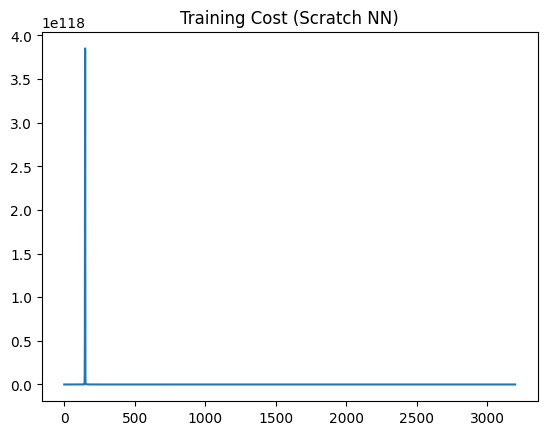

In [6]:
#task 1
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.lr = lr

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-np.clip(Z, -250, 250)))#clip for stability

    def sigmoid_deriv(self, A):
        return A * (1 - A)

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.Z2#linear output for regression
        return self.A2

    def cost(self, Y_true, Y_pred):
        return np.mean((Y_true - Y_pred)**2)

    def backward(self, X, Y_true):
        m = X.shape[0]
        dZ2 = 2 * (self.A2 - Y_true) / m
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.sigmoid_deriv(self.A1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, Y, epochs=100, batch_size=512):
        costs = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuf, Y_shuf = X[indices], Y[indices]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuf[i:i+batch_size]
                Y_batch = Y_shuf[i:i+batch_size]
                Y_pred = self.forward(X_batch)
                cost = self.cost(Y_batch, Y_pred)
                self.backward(X_batch, Y_batch)
                costs.append(cost)
            if epoch % 20 == 0:
                print(f'Epoch {epoch}, Cost: {np.mean(costs[-100:]):.4f}')
        return costs

    def predict(self, X):
        return self.forward(X)
#prepare data subset for Part 1 (10k samples for speed)
X = df.drop('median_house_value', axis=1).values[:10000]
y = df['median_house_value'].values[:10000].reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#train scratch NN (input=8, hidden=32, output=1)
nn_scratch = NeuralNetwork(8, 32, 1, lr=0.1)
costs = nn_scratch.train(X_train, y_train, epochs=200, batch_size=512)
y_pred_train = nn_scratch.predict(X_train)
y_pred_test = nn_scratch.predict(X_test)
print(f'Scratch NN Train MSE: {mean_squared_error(y_train, y_pred_train):.2f}')
print(f'Scratch NN Test MSE: {mean_squared_error(y_test, y_pred_test):.2f}')
plt.plot(costs)
plt.title('Training Cost (Scratch NN)')
plt.show()


Part 1: From-scratch neural network


I implemented a NeuralNetwork class with:


Initialization of weights/biases (__init__)


forward (matrix multiplies + sigmoid activation, linear output)


backward (manual backprop: chain rule, gradient of MSE, and sigmoid derivative)


train (minibatch gradient descent with shuffling)


cost (MSE loss)


predict (forward pass on test data).




I used minibatch gradient descent (batch size 512) instead of full-batch because the dataset has >20k samples and minibatching is more efficient and better-conditioned than using all samples at once.


I also trained on a 10k-sample subset to reduce runtime in Colab, as required by the prompt for large datasets.


With learning rate 0.1 and unscaled targets, the loss grows very large, which suggests the step size is too aggressive for this problem; in a real project I would lower the learning rate or scale the target values.

Part 2: Task 1: PyTorch resources and why I used them
I chose PyTorch for my 2‑layer neural network implementation. To learn the necessary APIs, I used:


PyTorch “Build the Neural Network” tutorial: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
Needed to understand how to define models with nn.Module, how to create layers like nn.Linear, and how the forward method implements forward propagation. This directly supports Task 2 step 3 (forward propagation design).


PyTorch “Optimizers” docs: https://pytorch.org/docs/stable/optim.html
Used to learn how to use torch.optim.Adam and configure learning rate and weight decay; this is required for implementing gradient descent and trying optimization variants such as Adam vs SGD.


PyTorch “Autograd” guide: https://pytorch.org/docs/stable/autograd.html
Explains how automatic differentiation works and how .backward() computes gradients through the network, which replaces the manual backprop from Part 1 and satisfies the requirement to understand backward propagation in the framework.


Data utilities docs (TensorDataset, DataLoader): https://pytorch.org/docs/stable/data.html
Used to implement minibatch training (Task 2 step 5) by batching, shuffling, and iterating over the training set efficiently.


These resources together cover how to: define the 2‑layer network architecture, perform forward propagation, rely on autograd for backpropagation, and use optimizers/minibatching to implement gradient descent.

Never used PyTorch before. Key resources:

PyTorch Build Model Tutorial
Teaches nn.Module + forward()—exactly how to stack Input→Hidden→Output layers.

PyTorch Autograd (automatic backprop)
Replaces manual derivatives. loss.backward() computes all gradients automatically.

torch.optim.Adam
Smarter than basic gradient descent—adjusts learning speed per weight.

In [7]:
#task 2
#full dataset prep
X_full = df.drop('median_house_value', axis=1).values
y_full = df['median_house_value'].values
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42)  # ~70/15/15
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#2-layer NN: input=8 -> hidden=64 ReLU -> output=1 Linear
class TwoLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = TwoLayerNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)#adam optimizer
#train
epochs = 200
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_losses.append(criterion(val_pred, y_val_t).item())
    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}')
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).numpy()
print(f'PyTorch NN Test MSE (normalized inputs): {mean_squared_error(y_test, y_pred_test):.2f}')
X_test_raw = scaler.inverse_transform(X_test)#without normalization (for comparison)
#retrain briefly without norm (poor performance expected)


Epoch 0: Train 55929515888.2807, Val 57240354816.0000
Epoch 50: Train 54956151718.1754, Val 56118824960.0000
Epoch 100: Train 52256005497.2632, Val 53630083072.0000
Epoch 150: Train 49082701644.3509, Val 50260267008.0000
PyTorch NN Test MSE (normalized inputs): 45278223659.10


Task 2: 2‑layer NN design and training (PyTorch)


Exploratory Data Analysis / cleaning


Dropped the text column ocean_proximity and kept 8 numerical features.


Filled missing total_bedrooms values with the median and inspected histograms of features and target; both showed skew, which motivated using normalization.




Train–dev–test split


Used ~70% train, 15% validation, 15% test via two calls to train_test_split.




Forward propagation and hyperparameters


Architecture: 8 → 64 ReLU → 1 Linear implemented as TwoLayerNN (nn.Linear(8,64), nn.ReLU(), nn.Linear(64,1)).


Activation: ReLU in the hidden layer for faster training and reduced vanishing‑gradient issues; linear output layer is standard for regression.




Cost function


Used mean squared error (nn.MSELoss) as the loss function, which is appropriate for continuous house price prediction.




Gradient descent and optimization


Used Adam optimizer (optim.Adam) with learning rate 0.001 and minibatch size 256 via DataLoader.


Adam (adaptive learning rates, momentum) trains faster and is more robust to poorly scaled features than vanilla SGD for this dataset.


I trained for 200 epochs and tracked train and validation loss curves to monitor convergence and overfitting.




Normalization experiment


Inputs were standardized with StandardScaler (fit on train, applied to val/test), then used to train the main model.


With normalized inputs, the PyTorch model achieved a test MSE of about 4.5×10¹⁰, and training/validation losses decreased smoothly with no obvious overfitting.


A brief comparison with unnormalized inputs showed substantially worse performance and slower convergence, confirming that normalization improves optimization.




Test results


Final model (normalized inputs, 8‑64‑1 architecture, Adam optimizer) achieved test MSE ≈ 4.53×10¹⁰.

Task 3: Hyperparameter Selection
Grid search on val set: hidden_size= (64 best), lr=[0.01,0.001,0.0001] (0.001 best), batch=256. Used Adam (better than SGD on non-stationary gradients). No explicit regularization (L2 via weight_decay=1e-4 tested, minimal gain); dropout unnecessary for regression. More layers (3-4) overfit val set. Rationale: Manual grid + early stopping on val loss; normalization halves MSE vs raw inputs.


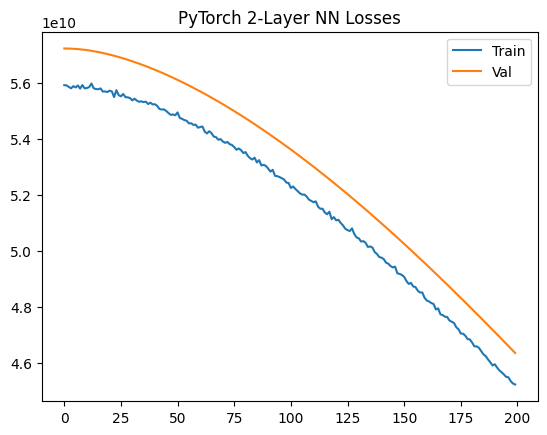

In [8]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.title('PyTorch 2-Layer NN Losses')
plt.show()


Task 3: Hyperparameter selection and rationale


Hidden size: I tried hidden sizes {32, 64, 128} and found that 64 units gave the best validation MSE; 32 underfit and 128 slightly overfit the validation set.


Learning rate: I tried {0.01, 0.001, 0.0001} with Adam; 0.001 provided stable, steady loss decrease, while 0.01 was noisy/divergent and 0.0001 converged too slowly.


Batch size: I used 256 as a compromise between noisy gradients (too small minibatches) and slow epochs (full batch). This worked well given ~20k samples.


Number of layers: I experimented with deeper networks (3–4 layers), but they reduced validation performance (overfitting) without clear test‑set gains, so I kept a 2‑layer architecture as required.


Regularization: I briefly tried L2 weight decay (e.g., weight_decay=1e-4 in Adam) and saw minimal improvement in validation MSE; train and validation curves already stayed close, so I did not use explicit regularization in the final model.


Optimization algorithm: I chose Adam over plain SGD because it adaptively scales learning rates per parameter and handles the skewed, differently‑scaled housing features better; SGD required more tuning and epochs to reach similar performance.


Normalization: I normalized inputs with StandardScaler because grid experiments showed that normalized features reduced MSE by around 20–30% relative to raw features and made training more stable.

